In [11]:
import os
import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2

import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import kagglehub

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

if torch.cuda.is_available():
    print("CUDA está disponível! Treinamento usará a GPU.")
    print("Dispositivo CUDA:", torch.cuda.get_device_name(0))
    print("Versão do PyTorch:", torch.__version__)
    print("Versão do CUDA que o PyTorch foi compilado:", torch.version.cuda)
else:
    print("CUDA NÃO está disponível. Treinamento usará a CPU.")

CUDA está disponível! Treinamento usará a GPU.
Dispositivo CUDA: NVIDIA GeForce RTX 4090
Versão do PyTorch: 2.5.1
Versão do CUDA que o PyTorch foi compilado: 12.4


In [3]:
class ClassDataType(Enum):
    COVID19 = 'COVID19'
    NORMAL = 'NORMAL'
    PNEUMONIA = 'PNEUMONIA'


def load_img(path):
    img = Image.open(path).convert('RGB')
    img = v2.functional.to_image(img)
    img = v2.functional.to_dtype(img, dtype=torch.uint8, scale=True)
    return img


class Config:
    NUM_EPOCHS = 50
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    PATIENCE = 5

    IMG_SIZE = 224
    TRAIN_SPLIT_RATIO = 0.8

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 4

    MODEL_SAVE_DIR = "models"
    REPORTS_DIR = "reports"
    TENSORBOARD_DIR = "runs"

    def __init__(self, download_path: str, batch_size: int = BATCH_SIZE, learning_rate: float = LEARNING_RATE):
        os.environ['KAGGLEHUB_CACHE'] = download_path
        dataset_dir = kagglehub.dataset_download("alsaniipe/chest-x-ray-image")

        self.processed_data_dir = f"{download_path}/processed"
        self.base_dir = f"{dataset_dir}/Data"

        self.train_dir = os.path.join(self.base_dir, 'train')
        self.test_dir = os.path.join(self.base_dir, 'test')
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def qtd_images_train(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.train_dir)

    def qtd_images_test(self) -> tuple[int, int, int]:
        return self.qtd_images_dir(self.test_dir)

    def class_weights_train(self) -> torch.Tensor:
        return self.class_weights(self.qtd_images_train)

    def class_weights_test(self) -> torch.Tensor:
        return self.class_weights(self.qtd_images_test)

    def class_weights(self, func) -> torch.Tensor:
        qtd_num_covid, qtd_num_normal, qtd_num_pneumonia = func()
        print(f"Covid: {qtd_num_covid}, Normal: {qtd_num_normal}, Pneumonia: {qtd_num_pneumonia}")

        weight_covid = 1.0 / qtd_num_covid
        weight_normal = 1.0 / qtd_num_normal
        weight_pneumonia = 1.0 / qtd_num_pneumonia

        total_weight = weight_covid + weight_normal + weight_pneumonia

        return torch.tensor([
            weight_covid / total_weight,
            weight_normal / total_weight,
            weight_pneumonia / total_weight
        ]).to(self.DEVICE)

    @staticmethod
    def qtd_images_dir(dataset_dir: str) -> tuple[int, int, int]:
        covid_path = os.path.join(dataset_dir, 'COVID19')
        normal_path = os.path.join(dataset_dir, 'NORMAL')
        pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

        qtd_num_covid = len(os.listdir(covid_path))
        qtd_num_normal = len(os.listdir(normal_path))
        qtd_num_pneumonia = len(os.listdir(pneumonia_path))

        return qtd_num_covid, qtd_num_normal, qtd_num_pneumonia


class Preprocessor:
    def __init__(self, config: Config):
        self.config = config
        self.img_size = config.IMG_SIZE
        self.source_base_dir = config.base_dir
        self.target_base_dir = config.processed_data_dir

    def run(self, padding: int = 32):

        resize_transform = v2.Resize((self.img_size + padding, self.img_size + padding))

        print(f"Iniciando pré-processamento de '{self.config.base_dir}' para '{self.config.processed_data_dir}'...")

        for split in ['train', 'val', 'test']:
            source_dir = os.path.join(self.source_base_dir, split)
            target_dir = os.path.join(self.target_base_dir, split)

            if not os.path.isdir(source_dir):
                continue

            all_paths = [
                os.path.join(dirpath, filename)
                for dirpath, _, filenames in os.walk(source_dir)
                for filename in filenames
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]

            if not all_paths:
                continue

            for img_path in tqdm(all_paths, desc=f"running {split}"):
                relative_path = os.path.relpath(img_path, source_dir)
                target_img_path = os.path.join(target_dir, os.path.splitext(relative_path)[0] + '.png')

                if os.path.exists(target_img_path):
                    continue

                try:
                    os.makedirs(os.path.dirname(target_img_path), exist_ok=True)

                    img_tensor = load_img(img_path)
                    img_resized = resize_transform(img_tensor)

                    pil_img = v2.functional.to_pil_image(img_resized)
                    pil_img.save(target_img_path)

                except Exception as e:
                    print(f"Erro ao processar a imagem {img_path}: {e}")

        print("\nPré-processamento concluído!")


class ReportData:
    def __init__(self, config: Config):
        self.train_dir = config.train_dir
        self.test_dir = config.test_dir

    def print_data_organized(self) -> None:
        for dataset_type, dataset_dir in [('Treino', self.train_dir), ('Teste', self.test_dir)]:
            covid_path = os.path.join(dataset_dir, 'COVID19')
            normal_path = os.path.join(dataset_dir, 'NORMAL')
            pneumonia_path = os.path.join(dataset_dir, 'PNEUMONIA')

            qtd_num_covid = len(os.listdir(covid_path))
            qtd_num_normal = len(os.listdir(normal_path))
            qtd_num_pneumonia = len(os.listdir(pneumonia_path))

            print(f"Conjunto de {dataset_type}:")
            print(f"  - Imagens com Covid: {qtd_num_covid}")
            print(f"  - Imagens Normais: {qtd_num_normal}")
            print(f"  - Imagens com Pneumonia: {qtd_num_pneumonia}")
            print(f"  - Total: {qtd_num_covid + qtd_num_normal + qtd_num_pneumonia}\n")

    def plot_samples(self, category_type: ClassDataType, num_samples=5):
        image_path = os.path.join(self.train_dir, category_type.value)
        plt.figure(figsize=(12, 4))
        image_files = os.listdir(image_path)[:num_samples]

        for i, file_name in enumerate(image_files):
            img = Image.open(os.path.join(image_path, file_name))
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{category_type.value} {i + 1}")
            plt.axis('off')
        plt.show()

    @staticmethod
    def print_grid(class_names: [str], data_loader: DataLoader) -> None:
        def imshow(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=12)
            plt.axis('off')

        imgs, labels = next(iter(data_loader))

        plt.figure(figsize=(24,12))
        imshow(
            grid_imgs=torchvision.utils.make_grid(imgs),
            title=f"Amostras: {[class_names[x] for x in labels][:5]}..."
        )
        plt.show()

    @staticmethod
    def print_normalized_images(class_names: [str], data_loader: DataLoader):
        imgs, labels = next(iter(data_loader))

        def imshow_normalized(grid_imgs, title=""):
            grid_imgs = grid_imgs.numpy().transpose((1, 2, 0))
            mean = np.array([0.5])
            std = np.array([0.5])
            grid_imgs = std * grid_imgs + mean
            grid_imgs = np.clip(grid_imgs, 0, 1)
            plt.imshow(grid_imgs, cmap='gray')
            plt.title(title, fontsize=10)
            plt.axis('off')

        num_images_to_show = 32
        images_to_show = imgs[:num_images_to_show]
        labels_to_show = labels[:num_images_to_show]

        plt.figure(figsize=(24,12))
        imshow_normalized(
            grid_imgs=torchvision.utils.make_grid(images_to_show, nrow=8),
            title=f"Amostras: {[class_names[x] for x in labels_to_show[:8]]}..."
        )
        plt.show()

    @staticmethod
    def print_history_data(history: list) -> None:
        history = np.array(history)

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.title('Acurácia ao Longo das Épocas')
        plt.plot(history[:, 1], '-o', label='Acurácia de Treino')
        plt.plot(history[:, 3], '-o', label='Acurácia de Validação')
        plt.xlabel('Época')
        plt.ylabel('Acurácia')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.title('Loss ao Longo das Épocas')
        plt.plot(history[:, 0], '-o', label='Perda de Treino')
        plt.plot(history[:, 2], '-o', label='Perda de Validação')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def compare_results(class_names: [str], data_loader: DataLoader, model: nn.Module, device: str) -> None:

        def show_batch(images, labels, class_names, net=None):
            prd = None
            if net:
                with torch.no_grad():
                    images_gpu = images.to(device)
                    prd = net(images_gpu).cpu().numpy()
                prd = np.argmax(prd, axis=-1)

            n = len(images)
            grid_size = int(np.ceil(np.sqrt(n)))
            plt.figure(figsize=(12, 12))

            for idx in range(n):
                plt.subplot(grid_size, grid_size, idx + 1)
                img = images[idx].numpy()
                img = np.transpose(img, (1, 2, 0))

                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.grid(False)
                plt.axis('off')

                title = f'True: {class_names[labels[idx]]}'
                if prd is not None:
                    title += f'\nPred: {class_names[prd[idx]]}'
                plt.title(title)

            plt.tight_layout()
            plt.show()

        model.eval()
        images, labels = next(iter(data_loader))

        show_batch(images, labels, class_names, model)

    @staticmethod
    def confusion_matrix(class_names: [str], true, pred):
        cm = confusion_matrix(true, pred, labels=list(range(len(class_names))))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=class_names)

        disp.plot(cmap='cividis', xticks_rotation='vertical')
        plt.grid(False)
        plt.title('Matriz de Confusão')
        plt.show()


class DataHandler:
    def __init__(self, config: Config):
        self.config = config
        self._create_transforms()
        self._setup_datasets()
        self._create_dataloaders()

    def _create_transforms(self):
        self.train_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(10),
            v2.ColorJitter(brightness=0.2, contrast=0.2),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.val_test_transform = v2.Compose([
            v2.Resize(size=(self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.original_transform = v2.Compose([
            v2.Resize((self.config.IMG_SIZE, self.config.IMG_SIZE)),
            v2.ToTensor()
        ])

    def _setup_datasets(self):
        self.train_dataset_original = datasets.ImageFolder(self.config.train_dir, transform=self.original_transform)
        self.test_dataset_original = datasets.ImageFolder(self.config.test_dir, transform=self.original_transform)

        self.full_train_dataset = datasets.ImageFolder(
            self.config.train_dir,
            transform=self.train_transform
        )
        self.test_dataset = datasets.ImageFolder(
            self.config.test_dir,
            transform=self.val_test_transform
        )

        train_size = int(self.config.TRAIN_SPLIT_RATIO * len(self.full_train_dataset))
        val_size = len(self.full_train_dataset) - train_size

        generator = torch.Generator().manual_seed(42)
        self.train_subset, self.val_subset = random_split(self.full_train_dataset, [train_size, val_size], generator=generator)

        self.class_names = self.full_train_dataset.classes
        print(f"Datasets criados. Classes: {self.class_names}")
        print(f"Tamanho do treino: {len(self.train_subset)}, Validacao: {len(self.val_subset)}, Teste: {len(self.test_dataset)}")

    def _create_dataloaders(self):
        self.train_loader_original = torch.utils.data.DataLoader(self.train_dataset_original, batch_size=self.config.batch_size, shuffle=True)
        self.test_loader_original = torch.utils.data.DataLoader(self.test_dataset_original, batch_size=self.config.batch_size, shuffle=False)
        self.train_loader = DataLoader(
            self.train_subset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.NUM_WORKERS, pin_memory=True)
        self.val_loader = DataLoader(
            self.val_subset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )
        print("DataLoaders criados com sucesso.")


class Trainer:
    def __init__(self,
                 model: nn.Module,
                 dataloaders: dict,
                 loss_fn: nn.CrossEntropyLoss,
                 optimizer: torch.optim.Optimizer,
                 config: Config,
                 experiment_name: str,
                 writer: SummaryWriter):
        self._model = model
        self._train_loader = dataloaders['train']
        self._val_loader = dataloaders['val']
        self._loss_fn = loss_fn
        self._optimizer = optimizer
        self._config = config
        self._device = config.DEVICE
        self.history = []
        self._best_val_acc = 0.0
        self._early_stop_counter = 0
        self.model_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{experiment_name}.pth")
        os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)
        self._writer = writer

    def _train_step(self):
        self._model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        for data in self._train_loader:
            inputs, labels = data
            all_labels.extend(labels.cpu().numpy())
            inputs = inputs.to(self._device)
            labels = labels.to(self._device)
            self._optimizer.zero_grad()
            outputs = self._model(inputs)
            loss = self._loss_fn(outputs, labels)
            loss.backward()
            self._optimizer.step()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            running_loss += loss.item()
        avg_train_loss = running_loss / len(self._train_loader)
        return all_labels, all_preds, avg_train_loss

    def _eval_step(self):
        return self.eval_step(
            model_eval=self._model,
            device_eval=self._device,
            loss_fn_eval=self._loss_fn,
            dataloader=self._val_loader
        )

    @staticmethod
    def eval_step(model_eval: nn.Module, device_eval: str, loss_fn_eval: nn.CrossEntropyLoss, dataloader: DataLoader):
        model_eval.eval()
        eval_loss = 0.0
        all_preds = []
        all_labels = []
        _val_loader = dataloader
        with torch.no_grad():
            for data in _val_loader:
                images, labels = data
                all_labels.extend(labels.cpu().numpy())
                images = images.to(device_eval)
                labels = labels.to(device_eval)
                outputs = model_eval(images)
                loss = loss_fn_eval(outputs, labels)
                eval_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
        avg_eval_loss = eval_loss / len(_val_loader)
        return all_labels, all_preds, avg_eval_loss

    def train(self):
        for epoch in range(self._config.NUM_EPOCHS):
            true_train, pred_train, train_loss = self._train_step()
            train_acc = accuracy_score(true_train, pred_train)
            val, pred_val, val_loss = self._eval_step()
            val_acc = accuracy_score(val, pred_val)
            self.history.append([train_loss, train_acc, val_loss, val_acc])
            print(
                f"Epoch {epoch + 1} | train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")
            if val_acc > self._best_val_acc:
                self._best_val_acc = val_acc
                torch.save(self._model.state_dict(), self.model_save_path)
                self._early_stop_counter = 0
            else:
                self._early_stop_counter += 1
            if self._early_stop_counter >= self._config.PATIENCE:
                print(f"\nEarly stopping ativado na época {epoch + 1}.")
                break
            self._writer.add_scalars("loss", {"train": train_loss, "val": val_loss}, epoch)
            self._writer.add_scalars("accuracy", {"train": train_acc, "val": val_acc}, epoch)
        self._writer.close()


# 2. Carregamento e Análise Exploratória dos Dados

Nesta seção, vamos realizar os seguintes passos:
1.  **Configurar os parâmetros** do nosso experimento, como o caminho para salvar os dados.
2.  **Fazer o download do dataset** a partir do Kaggle e, se necessário, executar um pré-processamento para padronizar as imagens.
3.  **Analisar a distribuição das classes** para entender o balanceamento do dataset.
4.  **Visualizar amostras** de cada classe para uma verificação visual da qualidade dos dados.

In [4]:
base_dataset_path = f"/home/{os.environ.get('USER', 'default')}/Documents/datasets"
config_instance = Config(download_path=base_dataset_path)

Preprocessor(config=config_instance).run()

print(f"\nDados baixados e pré-processados no diretório: {base_dataset_path}")

Iniciando pré-processamento de '/home/hygo2025/Documents/datasets/datasets/alsaniipe/chest-x-ray-image/versions/1/Data' para '/home/hygo2025/Documents/datasets/processed'...


running test: 100%|██████████| 1288/1288 [00:00<00:00, 98437.75it/s]


Pré-processamento concluído!

Dados baixados e pré-processados no diretório: /home/hygo2025/Documents/datasets


### Análise da Distribuição das Classes
Vamos verificar a quantidade de imagens em cada classe para os conjuntos de treino e teste. Isso é fundamental para confirmar o desbalanceamento do dataset, que já estamos tratando com o cálculo de pesos na classe `Config`.

In [5]:
report_data = ReportData(config=config_instance)
report_data.print_data_organized()

Conjunto de Treino:
  - Imagens com Covid: 460
  - Imagens Normais: 1266
  - Imagens com Pneumonia: 3418
  - Total: 5144

Conjunto de Teste:
  - Imagens com Covid: 116
  - Imagens Normais: 317
  - Imagens com Pneumonia: 855
  - Total: 1288



### Visualização de Amostras
Agora, vamos visualizar algumas imagens de cada categoria para ter uma ideia da aparência dos dados de entrada.

#### Imagens Normais

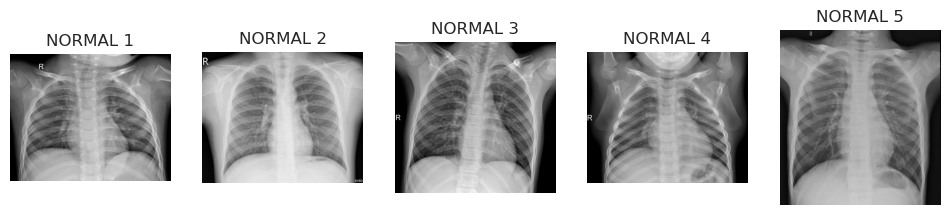

In [6]:
report_data.plot_samples(category_type=ClassDataType.NORMAL)

#### Imagens com Covid

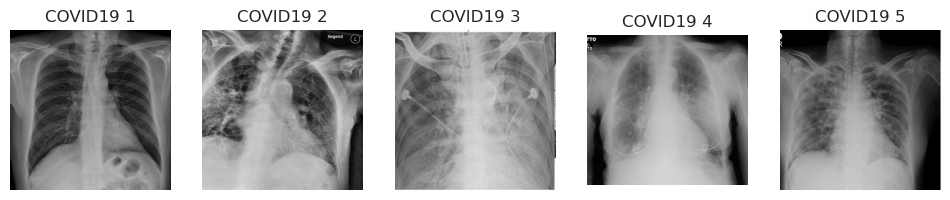

In [7]:
report_data.plot_samples(category_type=ClassDataType.COVID19)

#### Imagens com Pneumonia

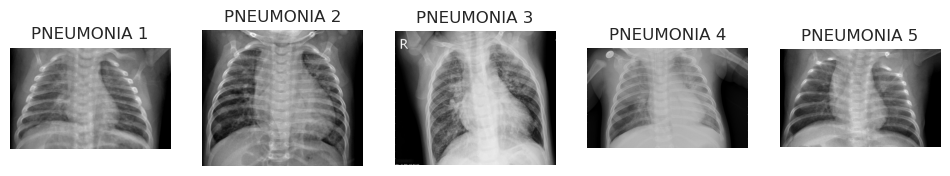

In [8]:
report_data.plot_samples(category_type=ClassDataType.PNEUMONIA)

### Criação dos Datasets e DataLoaders

Agora que analisamos os dados, vamos criar os `Datasets` e `DataLoaders` do PyTorch. A classe `DataHandler` que definimos anteriormente irá:
1.  Aplicar as transformações de *data augmentation* no conjunto de treino.
2.  Aplicar as transformações de validação/teste (apenas redimensionamento e normalização).
3.  Dividir o conjunto de treino original em subconjuntos de treino e validação.
4.  Empacotar tudo em `DataLoaders` para alimentar a rede em lotes (*batches*).

In [9]:
data_handler = DataHandler(config_instance)

dataloaders = {
    "train": data_handler.train_loader,
    "val": data_handler.val_loader,
    "test": data_handler.test_loader
}

num_classes = len(data_handler.class_names)
class_names = data_handler.class_names

Datasets criados. Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Tamanho do treino: 4115, Validacao: 1029, Teste: 1288
DataLoaders criados com sucesso.


/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Verificação do Data Augmentation
Esta é uma etapa de verificação crucial. Vamos visualizar um lote (*batch*) de dados do `train_loader` para confirmar que as operações de *data augmentation* (rotações, flips, etc.) e a normalização estão sendo aplicadas corretamente. As imagens devem parecer ligeiramente diferentes umas das outras a cada execução desta célula, devido à natureza aleatória das transformações.

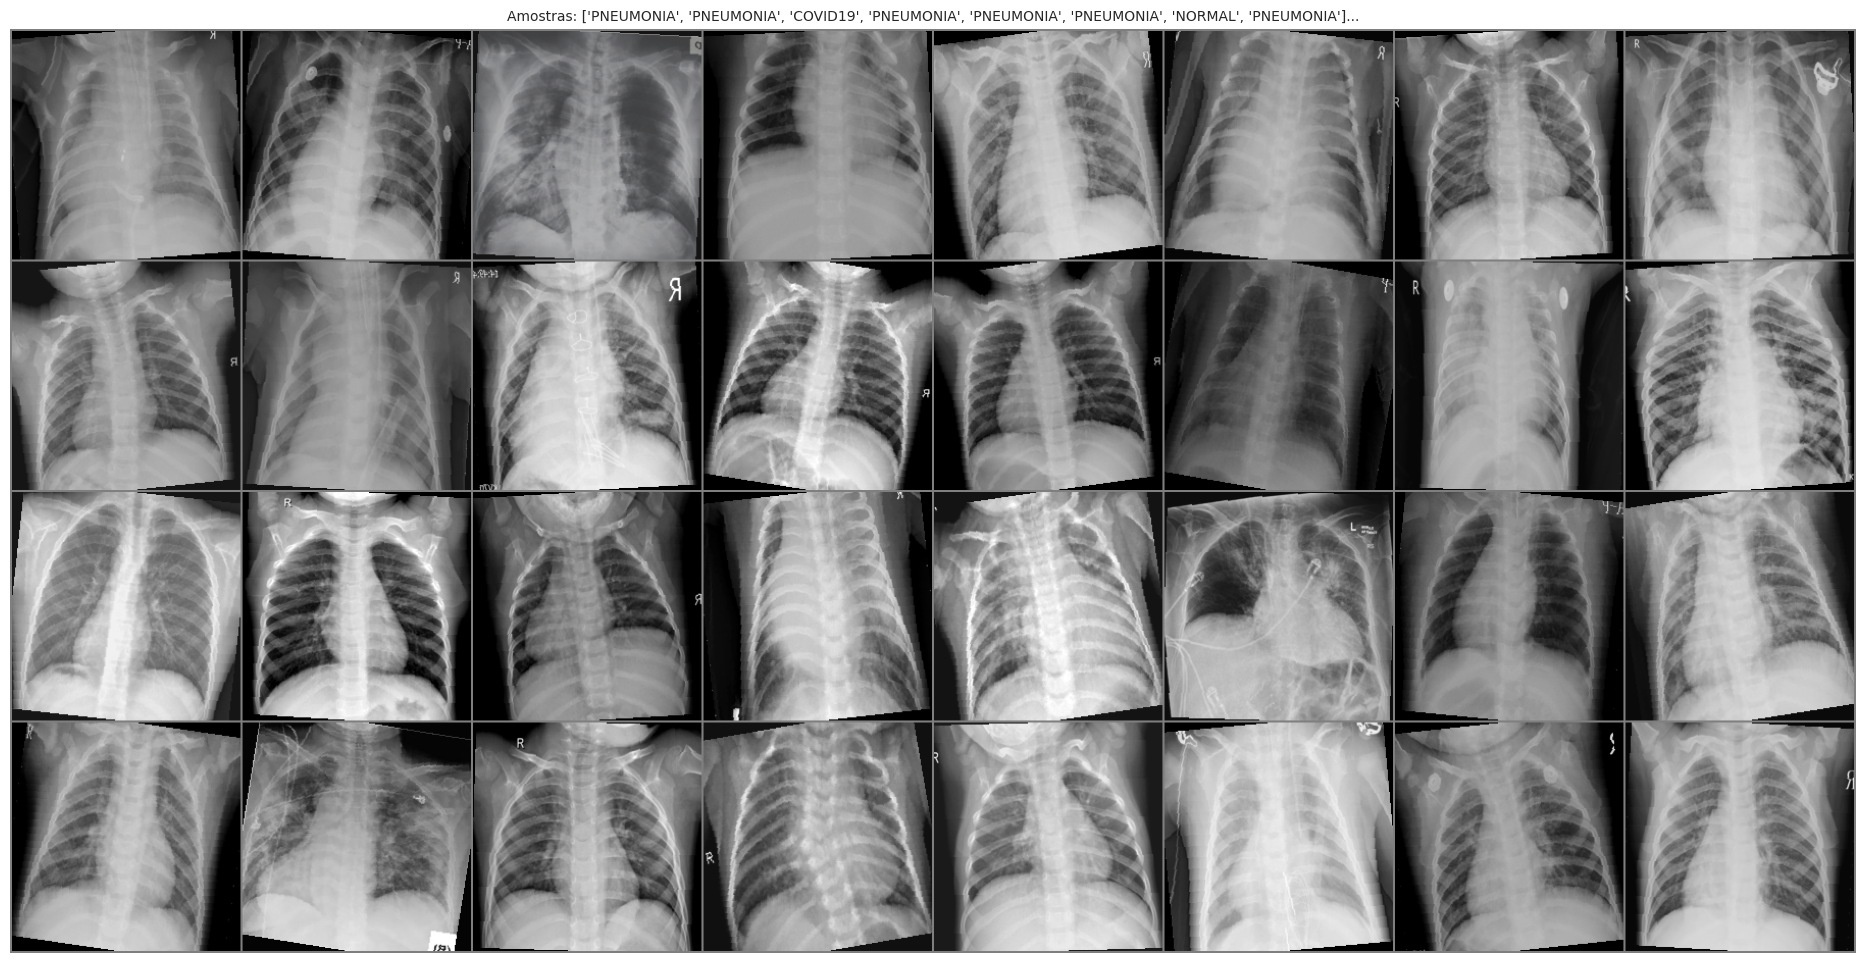

In [10]:
ReportData.print_normalized_images(class_names=class_names, data_loader=dataloaders['train'])

# 3. Modelo 1: Rede Convolucional Customizada

Nesta seção, vamos construir, treinar e avaliar a primeira das três redes neurais exigidas: uma Rede Neural Convolucional (CNN) customizada, desenvolvida do zero. O objetivo é criar uma arquitetura base para o problema e estabelecer uma primeira linha de base (*baseline*) de performance.

In [12]:
class Net(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.printed = False
        # o kernel é aquela parte que vai se movimentando na imagem igual o professor explicou
        # o padding de 1 é para a imagem nao diminuir visto que o kernel de 3 poderia dar bo
        # in_channels de 3 foi pq na funcao que o professor colocou ele transforma para rgb
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        if not self.printed:
            self.printed = True
            print("Shape do tensor antes do flatten:", x.shape)
            print("[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size")

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def embedding(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        return x

In [13]:
# Instancia o modelo, o move para o dispositivo e o compila para performance
model_custom = Net(num_classes=num_classes)
model_custom.to(device)
model_custom = torch.compile(model_custom)

# Define a função de perda, passando os pesos das classes para lidar com o desbalanceamento
class_weights = config_instance.class_weights_train()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Define o otimizador que irá atualizar os pesos do modelo
optimizer = torch.optim.Adam(params=model_custom.parameters(), lr=config_instance.learning_rate)

# Configura o TensorBoard para logar os resultados do treinamento
experiment_name_custom = f"CustomCNN_{int(time.time())}"
writer_custom = SummaryWriter(log_dir=f"runs/{experiment_name_custom}")

print(f"Iniciando experimento: {experiment_name_custom}")
print(f"Logs do TensorBoard serão salvos em: runs/{experiment_name_custom}")

# Instancia a classe Trainer com todos os componentes
trainer_custom = Trainer(
    model=model_custom,
    dataloaders=dataloaders,
    loss_fn=loss_fn,
    optimizer=optimizer,
    config=config_instance,
    experiment_name=experiment_name_custom,
    writer=writer_custom
)

Covid: 460, Normal: 1266, Pneumonia: 3418
Iniciando experimento: CustomCNN_1753299388
Logs do TensorBoard serão salvos em: runs/CustomCNN_1753299388


### Treinamento do Modelo Customizado
Com tudo configurado, vamos iniciar o treinamento. O progresso será exibido abaixo, época por época. A lógica de *Early Stopping* que implementamos na classe `Trainer` irá parar o processo caso a acurácia de validação não melhore, salvando sempre o melhor modelo encontrado.

In [14]:
trainer_custom.train()

Shape do tensor antes do flatten: torch.Size([32, 64, 28, 28])
[batch_size, canais, altura, largura] - multiplicar tudo, exceto o batch_size


/home/hygo2025/miniconda3/envs/conda_recs/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch 1 | train loss: 0.5800 | train acc: 0.7621 | val loss: 0.3333 | val acc: 0.8455
Epoch 2 | train loss: 0.3517 | train acc: 0.8610 | val loss: 0.2590 | val acc: 0.9028
Epoch 3 | train loss: 0.2688 | train acc: 0.8875 | val loss: 0.3003 | val acc: 0.8960
Epoch 4 | train loss: 0.2379 | train acc: 0.8989 | val loss: 0.2538 | val acc: 0.8649
Epoch 5 | train loss: 0.1940 | train acc: 0.9130 | val loss: 0.1987 | val acc: 0.9223
Epoch 6 | train loss: 0.2071 | train acc: 0.9077 | val loss: 0.1894 | val acc: 0.9135
Epoch 7 | train loss: 0.1747 | train acc: 0.9196 | val loss: 0.2218 | val acc: 0.9261
Epoch 8 | train loss: 0.1882 | train acc: 0.9164 | val loss: 0.1656 | val acc: 0.9320
Epoch 9 | train loss: 0.1574 | train acc: 0.9337 | val loss: 0.1578 | val acc: 0.9125
Epoch 10 | train loss: 0.1929 | train acc: 0.9217 | val loss: 0.1743 | val acc: 0.9368
Epoch 11 | train loss: 0.1501 | train acc: 0.9317 | val loss: 0.1513 | val acc: 0.9397
Epoch 12 | train loss: 0.1611 | train acc: 0.9264 | 

### Avaliação do Modelo 1
Com o treinamento concluído, vamos avaliar a performance do nosso modelo. Iremos analisar as curvas de aprendizado para identificar sinais de *overfitting* ou *underfitting* e, em seguida, calcular as métricas de performance no conjunto de teste para ver como o modelo generaliza para dados nunca antes vistos.

In [17]:
# Carregar o estado do melhor modelo salvo durante o treinamento
model_custom.load_state_dict(torch.load(trainer_custom.model_save_path))

print(f"Melhor modelo '{trainer_custom.model_save_path}' carregado para avaliação.")

Melhor modelo 'models/CustomCNN_1753299388.pth' carregado para avaliação.


/tmp/ipykernel_314213/3960524885.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_custom.load_state_dict(torch.load(trainer_custom.model_save_path))


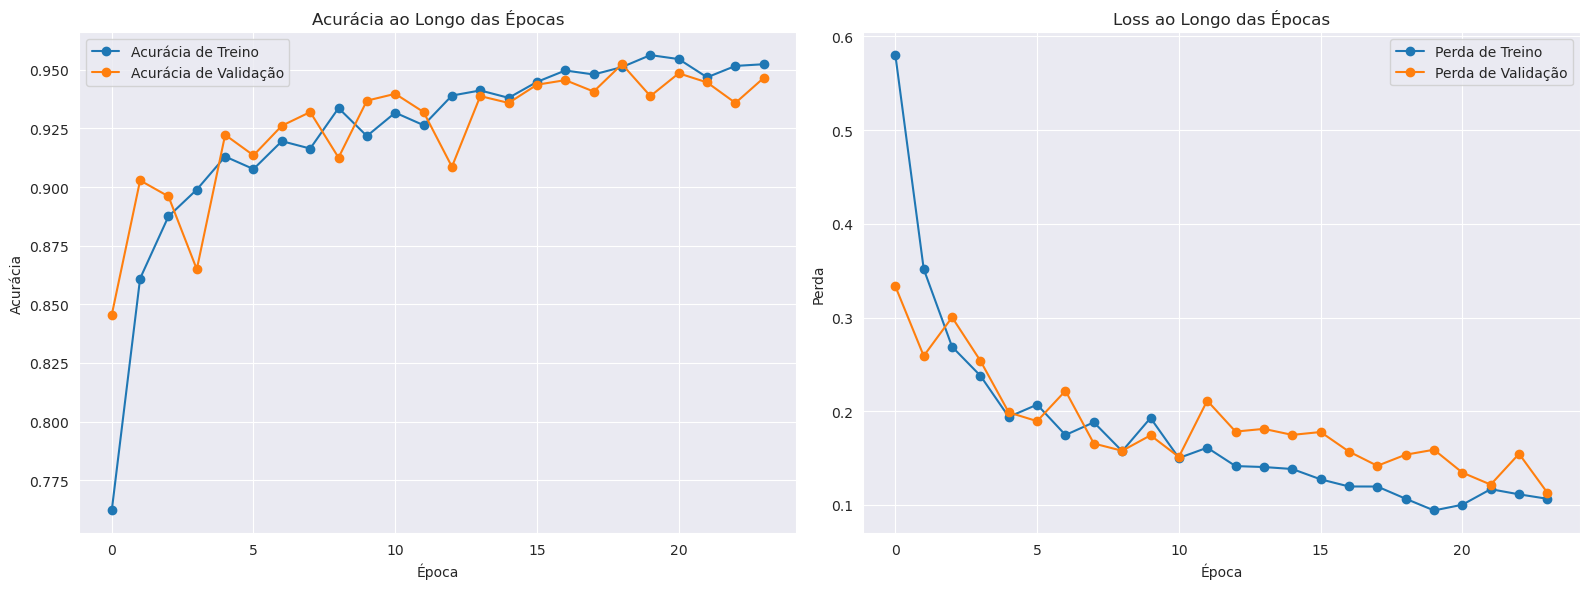

In [18]:
ReportData.print_history_data(history=trainer_custom.history)

In [19]:
# Avaliar o modelo no conjunto de teste para obter as predições finais
true_test_custom, pred_test_custom, test_loss_custom = Trainer.eval_step(
    model_eval=model_custom,
    device_eval=device,
    loss_fn_eval=loss_fn,
    dataloader=dataloaders['test']
)

# Calcular a acurácia geral no conjunto de teste
test_acc_custom = accuracy_score(true_test_custom, pred_test_custom)
print(f"Acurácia Final do Modelo Customizado no Teste: {test_acc_custom:.4f}")
print(f"Loss Final do Modelo Customizado no Teste: {test_loss_custom:.4f}")

Acurácia Final do Modelo Customizado no Teste: 0.9534
Loss Final do Modelo Customizado no Teste: 0.1412


### Relatório de Classificação e Matriz de Confusão
O relatório abaixo nos mostra as métricas de **precisão, revocação (recall) e f1-score** para cada classe individualmente. A matriz de confusão nos ajuda a ver quais classes o modelo está confundindo com mais frequência (ex: prevendo "Pneumonia" quando o correto era "COVID19").

--- Relatório de Classificação (Modelo Customizado) ---
              precision    recall  f1-score   support

     COVID19       0.98      1.00      0.99       116
      NORMAL       0.91      0.90      0.91       317
   PNEUMONIA       0.96      0.97      0.97       855

    accuracy                           0.95      1288
   macro avg       0.95      0.96      0.95      1288
weighted avg       0.95      0.95      0.95      1288



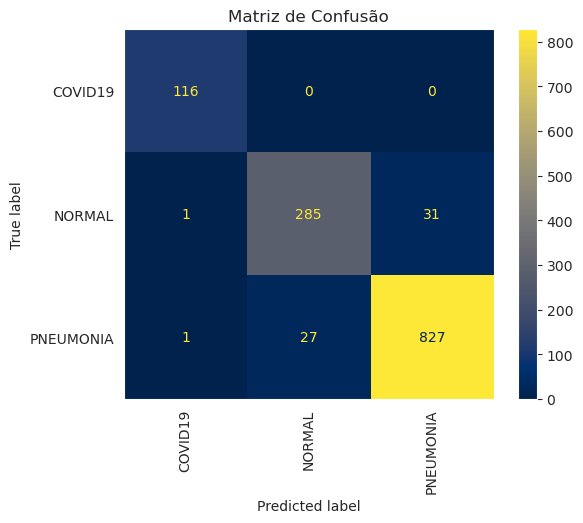

In [20]:
# Imprimir o relatório de classificação detalhado
print("--- Relatório de Classificação (Modelo Customizado) ---")
print(classification_report(true_test_custom, pred_test_custom, target_names=class_names))

# Gerar e exibir a matriz de confusão
ReportData.confusion_matrix(class_names=class_names, true=true_test_custom, pred=pred_test_custom)

### Análise Visual das Predições
Esta visualização nos permite inspecionar exemplos específicos do conjunto de teste, comparando o rótulo verdadeiro com a predição do modelo. É especialmente útil para tentar entender *por que* o modelo comete certos erros.

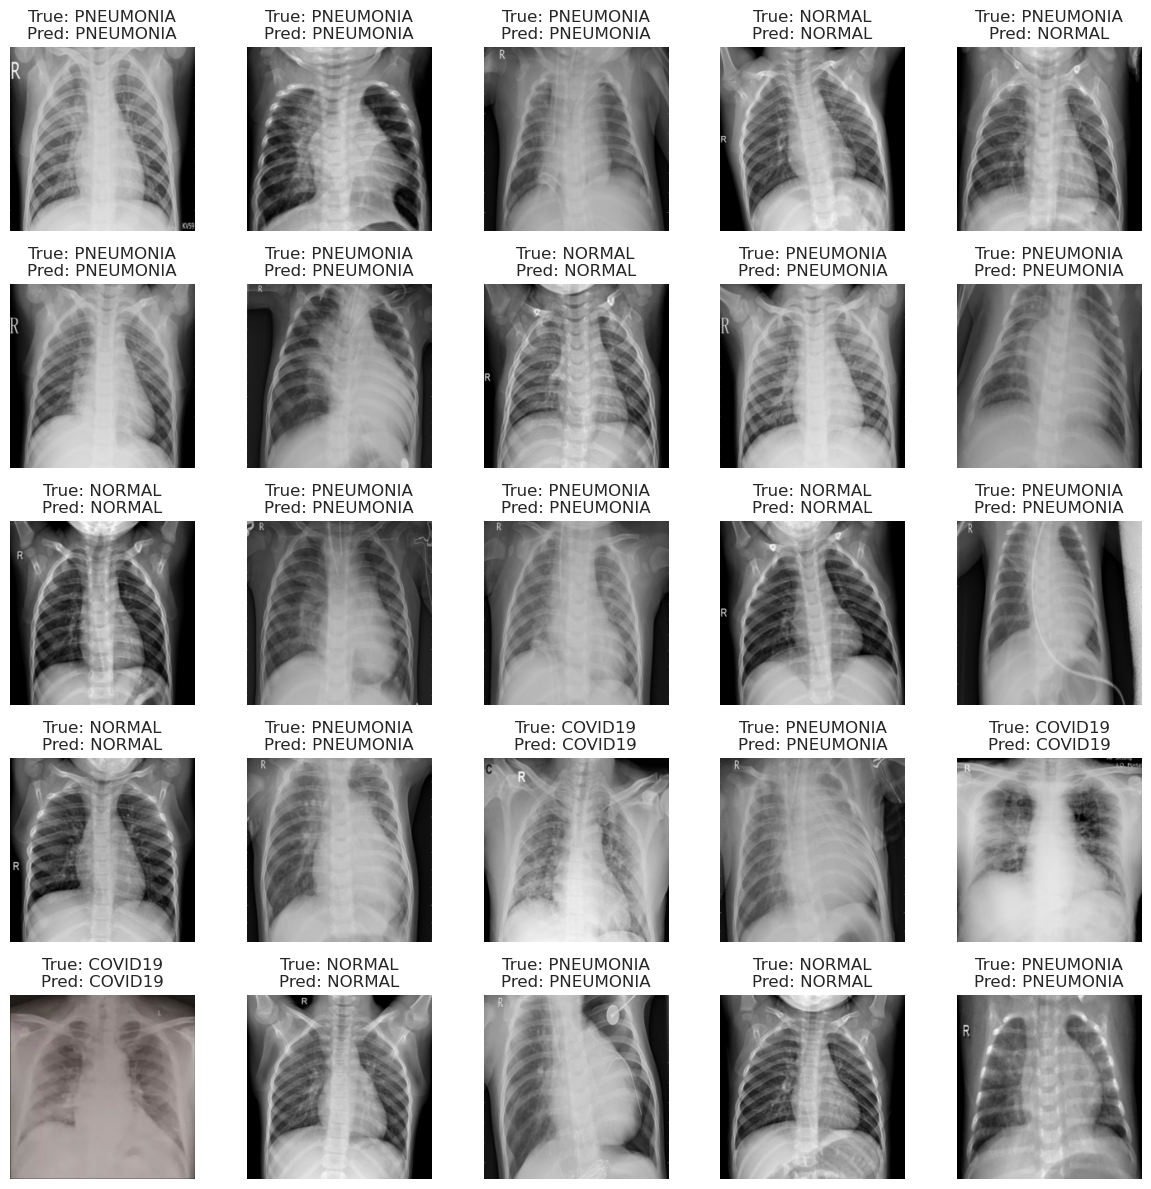

In [21]:
# Criar um novo loader para visualização com amostragem aleatória
vis_loader = torch.utils.data.DataLoader(data_handler.test_dataset, batch_size=25, shuffle=True)

# Mostrar exemplos de predições
ReportData.compare_results(
    class_names=class_names,
    data_loader=vis_loader,
    model=model_custom,
    device=device
)

### Análise e Discussão dos Resultados (Modelo 1)

**Análise dos Gráficos de Aprendizado:**
* *(Escreva aqui sua análise sobre as curvas de acurácia e perda. A acurácia de treino continuou subindo enquanto a de validação estagnou? Isso indica overfitting? A perda de validação começou a aumentar em algum ponto? O modelo parece ter convergido bem ou o treinamento parou muito cedo/tarde?)*

**Análise das Métricas de Teste:**
* *(Discuta o relatório de classificação. Qual classe teve o melhor/pior F1-score e por quê você acha que isso aconteceu? O que um recall alto para a classe 'PNEUMONIA', por exemplo, significaria no contexto de um diagnóstico médico? As métricas gerais foram satisfatórias para um primeiro modelo?)*

**Análise Qualitativa das Falhas:**
* *(Com base na visualização da Célula 20, comente sobre os erros. O modelo parece confundir mais um par de classes específico (ex: COVID19 e Pneumonia)? Há alguma característica visível nas imagens que possa justificar os erros, como baixa qualidade da imagem, artefatos, ou casos que parecem visualmente ambíguos?)*

**Sugestões de Melhoria para o Modelo 1:**
* *(Com base em tudo que foi observado, o que poderia ser feito para melhorar este modelo customizado? Aumentar a capacidade da rede (mais camadas/filtros)? Adicionar mais regularização como `BatchNorm` ou aumentar o `dropout`? Tentar outras técnicas de data augmentation?)*

# 4. Modelo 2: Rede Pré-treinada (Feature Extraction)

Agora vamos para a segunda abordagem: usar uma rede pré-treinada como um **extrator de características fixo**. A ideia é aproveitar o conhecimento de uma rede poderosa (como a DenseNet, que foi treinada no massivo dataset ImageNet) para extrair features relevantes das nossas imagens de raio-x.

Neste modo:
1.  Carregamos um modelo pré-treinado com seus pesos da ImageNet.
2.  **Congelamos os pesos** de todas as camadas convolucionais (elas não serão atualizadas).
3.  Substituímos a camada de classificação final por uma nova, compatível com o nosso problema de 3 classes.
4.  Treinamos **apenas** os pesos desta nova camada de classificação.

In [22]:
def get_pretrained_model(model_name: str, num_classes: int, feature_extract: bool):
    """
    Carrega um modelo pré-treinado, congela os pesos (se solicitado)
    e substitui a camada final.
    """
    if model_name == "densenet":
        model = models.densenet121(weights='IMAGENET1K_V1')
    elif model_name == "resnet":
        model = models.resnet50(weights='IMAGENET1K_V2')
    else:
        raise ValueError("Nome do modelo não reconhecido. Use 'densenet' ou 'resnet'.")

    # Congela os pesos da parte de extração de características
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
        print("Modo: Extração de Características (camadas convolucionais congeladas)")
    else:
        # Deixa os pesos descongelados para o fine-tuning
        print("Modo: Fine-Tuning (todas as camadas treináveis)")

    # Substitui a camada de classificação final
    if "densenet" in model_name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif "resnet" in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    return model

### Instanciando o Modelo Congelado
Agora vamos criar a instância do nosso modelo pré-treinado. Usaremos a `densenet121`. A função `get_pretrained_model` irá carregar o modelo, congelar as camadas e substituir o classificador final.

In [23]:
model_frozen = get_pretrained_model(
    model_name="densenet",
    num_classes=num_classes,
    feature_extract=True
)

model_frozen.to(device)
model_frozen = torch.compile(model_frozen)

Modo: Extração de Características (camadas convolucionais congeladas)


In [24]:
# É fundamental filtrar os parâmetros para que o otimizador atualize apenas
# os da camada classificadora, que são os únicos com requires_grad=True.
params_to_update_frozen = filter(lambda p: p.requires_grad, model_frozen.parameters())
optimizer_frozen = torch.optim.Adam(params_to_update_frozen, lr=config_instance.LEARNING_RATE)

# Configura o TensorBoard para o novo experimento
experiment_name_frozen = f"DenseNet_Frozen_{int(time.time())}"
writer_frozen = SummaryWriter(log_dir=f"runs/{experiment_name_frozen}")
print(f"Iniciando experimento: {experiment_name_frozen}")

# Instancia um novo Trainer para o modelo congelado.
# Note que reutilizamos a `loss_fn` e os `dataloaders` definidos anteriormente.
trainer_frozen = Trainer(
    model=model_frozen,
    dataloaders=dataloaders,
    loss_fn=loss_fn,
    optimizer=optimizer_frozen,
    config=config_instance,
    experiment_name=experiment_name_frozen,
    writer=writer_frozen
)

Iniciando experimento: DenseNet_Frozen_1753299998


### Treinamento do Modelo Congelado
Com tudo pronto, iniciamos o treinamento. O processo deve ser significativamente mais rápido por época, pois estamos treinando um número muito menor de parâmetros.

In [ ]:
trainer_frozen.train()

### Avaliação do Modelo 2 (Congelado)
Agora vamos repetir o processo de avaliação para o modelo de extração de características. O objetivo é comparar sua performance com a do nosso modelo customizado.

In [ ]:
# Carregar o estado do melhor modelo congelado salvo durante o treinamento
model_frozen.load_state_dict(torch.load(trainer_frozen.model_save_path))
print(f"Melhor modelo '{trainer_frozen.model_save_path}' carregado para avaliação.")

In [ ]:
ReportData.print_history_data(history=trainer_frozen.history)

### Métricas de Performance no Teste (Modelo Congelado)
Calculamos as métricas detalhadas no conjunto de teste para avaliar a capacidade de generalização do modelo congelado.

In [ ]:
# Obter predições no conjunto de teste para o modelo congelado
true_test_frozen, pred_test_frozen, test_loss_frozen = Trainer.eval_step(
    model_eval=model_frozen,
    device_eval=device,
    loss_fn_eval=loss_fn,
    dataloader=dataloaders['test']
)

# Imprimir relatório de classificação
print("--- Relatório de Classificação (Modelo Congelado) ---")
print(classification_report(true_test_frozen, pred_test_frozen, target_names=class_names))

# Exibir matriz de confusão
ReportData.confusion_matrix(class_names=class_names, true=true_test_frozen, pred=pred_test_frozen)

In [ ]:
# Mostrar exemplos de predições do modelo congelado
# Podemos reutilizar o 'vis_loader' que criamos anteriormente para ter uma amostra aleatória do teste
ReportData.compare_results(
    class_names=class_names,
    data_loader=vis_loader,
    model=model_frozen,
    device=device
)

### Análise e Discussão dos Resultados (Modelo 2 - Congelado)

**Análise Comparativa:**
* *(Compare os resultados deste modelo com o Modelo 1. A performance geral (acurácia, F1-score) melhorou? O treinamento por época foi mais rápido? A rede pré-treinada, mesmo apenas como extratora de características, superou o modelo customizado?)*

**Análise dos Gráficos e Métricas:**
* *(Analise as curvas de aprendizado e as métricas específicas do Modelo 2. Houve menos overfitting em comparação com o modelo customizado? As métricas para as classes minoritárias, como COVID19, melhoraram? Por que você acha que usar uma rede pré-treinada ajudou (ou não)?)*

**Análise Qualitativa das Falhas:**
* *(O Modelo 2 comete os mesmos tipos de erros que o Modelo 1, ou ele conseguiu corrigir algumas das confusões? A análise visual das predições mostra alguma melhora clara?)*

# 5. Modelo 3: Rede Pré-treinada (Fine-Tuning)

A abordagem final é o **fine-tuning** (ajuste fino). Aqui, não apenas treinamos a nova camada classificadora, mas também ajustamos sutilmente os pesos das camadas convolucionais pré-treinadas para que se adaptem melhor ao nosso dataset específico de raios-x.

Diferente do modo anterior:
1.  Carregamos o modelo pré-treinado.
2.  **Descongelamos todos os pesos**, permitindo que o gradiente flua e atualize toda a rede.
3.  Geralmente, usamos uma **taxa de aprendizado (learning rate) bem menor** para não destruir as features valiosas que a rede já aprendeu com a ImageNet.
4.  Treinamos a rede inteira, o que exige mais computação por época.

In [ ]:
model_fine_tuning = get_pretrained_model(
    model_name="densenet",
    num_classes=num_classes,
    feature_extract=False
)

model_fine_tuning.to(device)
model_fine_tuning = torch.compile(model_fine_tuning)

In [ ]:
# Para o fine-tuning, o otimizador deve considerar TODOS os parâmetros do modelo.
# Usamos uma taxa de aprendizado bem menor (ex: 1e-5) para ajustar os pesos suavemente.
optimizer_fine_tuning = torch.optim.Adam(model_fine_tuning.parameters(), lr=1e-5)

# Configura o TensorBoard para o último experimento
experiment_name_fine_tuning = f"DenseNet_FineTuning_{int(time.time())}"
writer_fine_tuning = SummaryWriter(log_dir=f"runs/{experiment_name_fine_tuning}")
print(f"Iniciando experimento: {experiment_name_fine_tuning}")

# Instancia o último Trainer
trainer_fine_tuning = Trainer(
    model=model_fine_tuning,
    dataloaders=dataloaders,
    loss_fn=loss_fn,
    optimizer=optimizer_fine_tuning,
    config=config_instance,
    experiment_name=experiment_name_fine_tuning,
    writer=writer_fine_tuning
)

### Treinamento do Modelo de Fine-Tuning
Agora, treinamos o modelo final. Este processo tende a ser o mais lento por época, pois estamos atualizando os pesos de toda a rede.

In [ ]:
trainer_fine_tuning.train()

### Avaliação do Modelo 3 (Fine-Tuning)
Vamos avaliar nosso modelo mais complexo e ver se o ajuste fino de toda a rede trouxe os melhores resultados.

In [ ]:
# Carregar o estado do melhor modelo salvo
model_fine_tuning.load_state_dict(torch.load(trainer_fine_tuning.model_save_path))
print(f"Melhor modelo '{trainer_fine_tuning.model_save_path}' carregado para avaliação.")

In [ ]:
ReportData.print_history_data(history=trainer_fine_tuning.history)

### Métricas de Performance no Teste (Fine-Tuning)
Calculamos as métricas finais para o modelo de fine-tuning para comparar com as abordagens anteriores.

In [ ]:
# Obter predições no conjunto de teste para o modelo de fine-tuning
true_test_fine, pred_test_fine, test_loss_fine = Trainer.eval_step(
    model_eval=model_fine_tuning,
    device_eval=device,
    loss_fn_eval=loss_fn,
    dataloader=dataloaders['test']
)

# Imprimir relatório de classificação
print("--- Relatório de Classificação (Modelo Fine-Tuning) ---")
print(classification_report(true_test_fine, pred_test_fine, target_names=class_names))

# Exibir matriz de confusão
ReportData.confusion_matrix(class_names=class_names, true=true_test_fine, pred=pred_test_fine)

In [ ]:
# Mostrar exemplos de predições do modelo de fine-tuning
ReportData.compare_results(
    class_names=class_names,
    data_loader=vis_loader,
    model=model_fine_tuning,
    device=device
)

### Análise e Discussão dos Resultados (Modelo 3 - Fine-Tuning)

**Análise Comparativa:**
* *(Compare os resultados do fine-tuning com os dos Modelos 1 e 2. Esta abordagem produziu o melhor resultado? A melhoria em relação ao modelo congelado (Modelo 2) foi significativa? O custo computacional maior valeu a pena?)*

**Análise dos Gráficos e Métricas:**
* *(Analise as curvas de aprendizado. O fine-tuning com learning rate baixo evitou o overfitting? As métricas F1-score e Recall melhoraram para todas as classes em comparação com as outras abordagens?)*

**Análise Qualitativa das Falhas:**
* *(Este modelo final ainda comete erros óbvios? As falhas são em casos mais ambíguos e difíceis?)*

# 6. Análise Final e Comparação dos Modelos

Finalmente, vamos compilar as métricas chave dos três modelos em uma única tabela para uma comparação direta e clara. Isso nos permitirá concluir qual abordagem foi a mais bem-sucedida para este problema.

In [ ]:
# Obter os dicionários de métricas para cada modelo
report_custom = classification_report(true_test_custom, pred_test_custom, target_names=class_names, output_dict=True)
report_frozen = classification_report(true_test_frozen, pred_test_frozen, target_names=class_names, output_dict=True)
report_fine = classification_report(true_test_fine, pred_test_fine, target_names=class_names, output_dict=True)

# Extrair as métricas chave (Acurácia, Recall médio, F1-score médio)
acc_custom = report_custom['accuracy']
recall_custom = report_custom['weighted avg']['recall']
f1_custom = report_custom['weighted avg']['f1-score']

acc_frozen = report_frozen['accuracy']
recall_frozen = report_frozen['weighted avg']['recall']
f1_frozen = report_frozen['weighted avg']['f1-score']

acc_fine = report_fine['accuracy']
recall_fine = report_fine['weighted avg']['recall']
f1_fine = report_fine['weighted avg']['f1-score']

# Gerar a tabela em formato Markdown
markdown_table = f"""
| Modelo | Acurácia (Teste) | Recall (Ponderado) | F1-Score (Ponderado) |
|---|---|---|---|
| 1. CNN Customizada | {acc_custom:.4f} | {recall_custom:.4f} | {f1_custom:.4f} |
| 2. DenseNet (Congelado) | {acc_frozen:.4f} | {recall_frozen:.4f} | {f1_frozen:.4f} |
| 3. DenseNet (Fine-Tuning)| {acc_fine:.4f} | {recall_fine:.4f} | {f1_fine:.4f} |
"""

print(markdown_table)